# Project: Multi-Task Learning Model for NER and Event Classification

This Jupyter Notebook presents a joint (multi-task) model architecture designed to solve two tasks simultaneously using the **NEREL** dataset:
1.  **NER (Named Entity Recognition):** Token-level classification using the BIO tagging scheme.
2.  **Event/Relation Classification:** Document-level multi-label classification.

## Notebook Structure

1.  **Environment Setup:** Configuration of paths, random seeds for reproducibility, and library imports.
2.  **Exploratory Data Analysis (EDA):** Loading JSONL data, dataset overview, visualization of class distributions, and key insights.
3.  **Data Parsing & Target Generation:** Utilization of NEREL string parsers and implementation of the data collection pipeline (`build_examples_from_nerel`).
4.  **Tokenization & Label Alignment:** Implementation of `tokenize_and_align_labels`, custom Dataset class, and Data Collator for batch processing.
5.  **Model Architecture & Loss Function:** Implementation of the `JointModel` class and a custom **uncertainty-weighted loss** to balance task learning.
6.  **Training & Validation:** Training loop execution, optimizer and scheduler configuration, and metric logging.
7.  **Inference & Error Analysis:** End-to-end inference pipeline and qualitative analysis of model predictions.


##### 1|2. EDA


In [ ]:
pip install datasets

In [ ]:
pip install seqeval

In [3]:
import random
import numpy as np
import torch

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

In [4]:
import json
import requests

# Function for downloading and reading a JSONL file
def load_jsonl(url):
    response = requests.get(url)
    response.raise_for_status()
    return [json.loads(line) for line in response.text.splitlines() if line.strip()]

base_url = "https://huggingface.co/datasets/iluvvatar/NEREL/resolve/main/data/"
train_url = base_url + "train.jsonl"
dev_url   = base_url + "dev.jsonl"
test_url  = base_url + "test.jsonl"

ent_types_url = "https://huggingface.co/datasets/iluvvatar/NEREL/resolve/main/ent_types.jsonl"
rel_types_url = "https://huggingface.co/datasets/iluvvatar/NEREL/resolve/main/rel_types.jsonl"

train = load_jsonl(train_url)
dev = load_jsonl(dev_url)
test = load_jsonl(test_url)
entities = load_jsonl(ent_types_url)
relations = load_jsonl(rel_types_url)




In [5]:
for i in range(50):
  print(train[i])

{'id': 0, 'text': 'Пулеметы, автоматы и снайперские винтовки изъяты в арендуемом американцами доме в Бишкеке\n\n05/08/2008 10:35\n\nБИШКЕК, 5 августа /Новости-Грузия/. Правоохранительные органы Киргизии обнаружили в доме, арендуемом гражданами США в Бишкеке, пулеметы, автоматы и снайперские винтовки, сообщает во вторник пресс-служба МВД Киргизии.\n\n"В ходе проведения оперативно-профилактического мероприятия под кодовым названием "Арсенал" в новостройке Ынтымак, в доме, принадлежащем 66-летнему гражданину Киргизии и арендуемом гражданами США, обнаружены и изъяты: шесть крупнокалиберных пулеметов с оптическим прицелом и с приборами ночного видения, 26 автоматов калибра 5,56 миллиметра, два винчестера марки МОСВЕГА 12-го калибра, четыре ствола от крупнокалиберного пулемета, два подствольных гранатомета, четыре снайперские винтовки с оптическим прицелом защитного цвета, шесть пистолетов калибра 9 миллиметров марки Беретта, одна винтовка", - говорится в сообщении МВД.\n\nПресс-служба отмеч

In [6]:
print(len(relations))
print(relations)

49
[{'type': 'ABBREVIATION', 'arg1': ['<ENTITY>'], 'arg2': ['<ENTITY>']}, {'type': 'KNOWS', 'arg1': ['PERSON', 'PROFESSION'], 'arg2': ['<ENTITY>']}, {'type': 'AGE_IS', 'arg1': ['<ENTITY>'], 'arg2': ['AGE']}, {'type': 'AGE_DIED_AT', 'arg1': ['PERSON', 'PROFESSION'], 'arg2': ['AGE']}, {'type': 'ALTERNATIVE_NAME', 'arg1': ['<ENTITY>'], 'arg2': ['<ENTITY>']}, {'type': 'AWARDED_WITH', 'arg1': ['PERSON', 'PROFESSION', 'ORGANIZATION', 'WORK_OF_ART', 'NATIONALITY'], 'arg2': ['AWARD']}, {'type': 'PLACE_OF_BIRTH', 'arg1': ['PERSON', 'PROFESSION'], 'arg2': ['CITY', 'COUNTRY', 'DISTRICT', 'FACILITY', 'LOCATION', 'STATE_OR_PROVINCE']}, {'type': 'CAUSE_OF_DEATH', 'arg1': ['PERSON', 'PROFESSION', 'NATIONALITY'], 'arg2': ['DISEASE', 'EVENT']}, {'type': 'DATE_DEFUNCT_IN', 'arg1': ['CITY', 'COUNTRY', 'DISTRICT', 'FACILITY', 'EVENT', 'ORGANIZATION', 'STATE_OR_PROVINCE', 'WORK_OF_ART'], 'arg2': ['DATE']}, {'type': 'DATE_FOUNDED_IN', 'arg1': ['CITY', 'COUNTRY', 'DISTRICT', 'FACILITY', 'EVENT', 'LOCATION', 

In [7]:
rel_cl = []
for relation in relations:
  rel_cl.append(relation['type'])

print(rel_cl)

['ABBREVIATION', 'KNOWS', 'AGE_IS', 'AGE_DIED_AT', 'ALTERNATIVE_NAME', 'AWARDED_WITH', 'PLACE_OF_BIRTH', 'CAUSE_OF_DEATH', 'DATE_DEFUNCT_IN', 'DATE_FOUNDED_IN', 'DATE_OF_BIRTH', 'DATE_OF_CREATION', 'DATE_OF_DEATH', 'POINT_IN_TIME', 'PLACE_OF_DEATH', 'FOUNDED_BY', 'HEADQUARTERED_IN', 'IDEOLOGY_OF', 'LOCATED_IN', 'SPOUSE', 'MEDICAL_CONDITION', 'MEMBER_OF', 'ORGANIZES', 'ORIGINS_FROM', 'OWNER_OF', 'PARENT_OF', 'PLACE_RESIDES_IN', 'PRICE_OF', 'PRODUCES', 'RELATIVE', 'RELIGION_OF', 'SCHOOLS_ATTENDED', 'SIBLING', 'SUBEVENT_OF', 'SUBORDINATE_OF', 'TAKES_PLACE_IN', 'WORKPLACE', 'WORKS_AS', 'START_TIME', 'END_TIME', 'CONVICTED_OF', 'PENALIZED_AS', 'PART_OF', 'HAS_CAUSE', 'AGENT', 'PARTICIPANT_IN', 'INANIMATE_INVOLVED', 'EXPENDITURE', 'INCOME']


In [8]:
print(len(entities))
print(entities)

29
[{'type': 'AGE', 'link': ''}, {'type': 'AWARD', 'link': '<NORM>:Wikidata'}, {'type': 'CITY', 'link': '<NORM>:Wikidata'}, {'type': 'COUNTRY', 'link': '<NORM>:Wikidata'}, {'type': 'CRIME', 'link': ''}, {'type': 'DATE', 'link': ''}, {'type': 'DISEASE', 'link': '<NORM>:Wikidata'}, {'type': 'DISTRICT', 'link': '<NORM>:Wikidata'}, {'type': 'EVENT', 'link': '<NORM>:Wikidata'}, {'type': 'FACILITY', 'link': '<NORM>:Wikidata'}, {'type': 'FAMILY', 'link': ''}, {'type': 'IDEOLOGY', 'link': '<NORM>:Wikidata'}, {'type': 'LANGUAGE', 'link': '<NORM>:Wikidata'}, {'type': 'LAW', 'link': '<NORM>:Wikidata'}, {'type': 'LOCATION', 'link': '<NORM>:Wikidata'}, {'type': 'MONEY', 'link': ''}, {'type': 'NATIONALITY', 'link': '<NORM>:Wikidata'}, {'type': 'NUMBER', 'link': ''}, {'type': 'ORDINAL', 'link': ''}, {'type': 'ORGANIZATION', 'link': '<NORM>:Wikidata'}, {'type': 'PENALTY', 'link': ''}, {'type': 'PERCENT', 'link': ''}, {'type': 'PERSON', 'link': '<NORM>:Wikidata'}, {'type': 'PRODUCT', 'link': '<NORM>:Wi

In [ ]:
ent_cl = []
for entity in entities:
  ent_cl.append(entity['type'])

print(ent_cl)

['AGE', 'AWARD', 'CITY', 'COUNTRY', 'CRIME', 'DATE', 'DISEASE', 'DISTRICT', 'EVENT', 'FACILITY', 'FAMILY', 'IDEOLOGY', 'LANGUAGE', 'LAW', 'LOCATION', 'MONEY', 'NATIONALITY', 'NUMBER', 'ORDINAL', 'ORGANIZATION', 'PENALTY', 'PERCENT', 'PERSON', 'PRODUCT', 'PROFESSION', 'RELIGION', 'STATE_OR_PROVINCE', 'TIME', 'WORK_OF_ART']


In [9]:
# collecting statistics on entities
import re
pattern = re.compile(r"^T\d+\t(\w+)\s")
ent_stats = {}
ent_in_text = []

for i in train:
  ent_in_text.append(len(i['entities']))
  for entity in i['entities']:
    if pattern.match(entity):
      ent_type = pattern.match(entity).group(1)
      if ent_type in ent_stats:
        ent_stats[ent_type] += 1
      else:
        ent_stats[ent_type] = 1

print(ent_stats)
ent_stats = sorted(ent_stats.items(), key=lambda item: item[1], reverse=True)[:15]

{'NATIONALITY': 629, 'CITY': 1846, 'DATE': 3886, 'COUNTRY': 3633, 'ORGANIZATION': 5776, 'AGE': 918, 'NUMBER': 1496, 'PRODUCT': 409, 'FACILITY': 594, 'TIME': 260, 'EVENT': 4755, 'PROFESSION': 7044, 'PERSON': 7779, 'STATE_OR_PROVINCE': 539, 'IDEOLOGY': 446, 'LANGUAGE': 70, 'PERCENT': 102, 'LOCATION': 408, 'ORDINAL': 810, 'DISTRICT': 160, 'DISEASE': 387, 'MONEY': 253, 'CRIME': 493, 'PENALTY': 306, 'LAW': 574, 'WORK_OF_ART': 492, 'FAMILY': 32, 'AWARD': 603, 'RELIGION': 142}


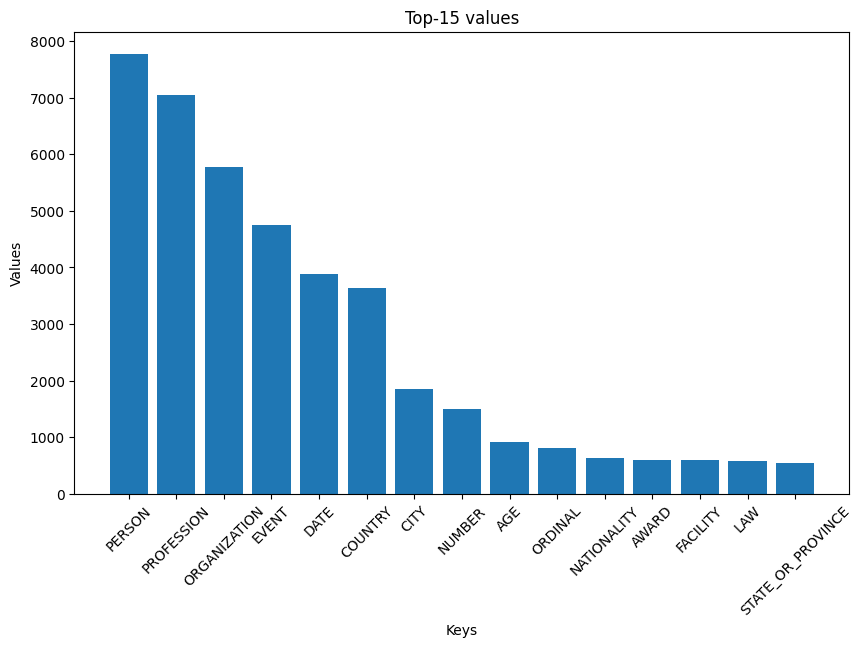

In [10]:
import matplotlib.pyplot as plt

labels, values = zip(*ent_stats)

plt.figure(figsize=(10,6))
plt.bar(labels, values)
plt.xticks(rotation=45)
plt.xlabel("Keys")
plt.ylabel("Values")
plt.title("Top-15 values")
plt.show()


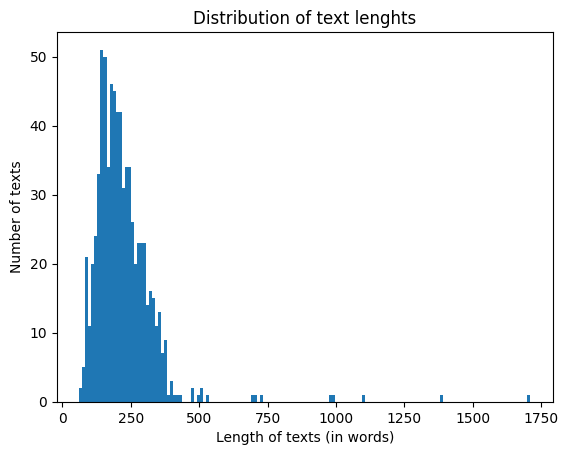

In [12]:
texts = []
for i in train:
  texts.append(i['text'])

# length of texts (in words)
lengths = [len(t.split()) for t in texts]

plt.hist(lengths, bins=150)
plt.xlabel("Length of texts (in words)")
plt.ylabel("Number of texts")
plt.title("Distribution of text lenghts")
plt.show()


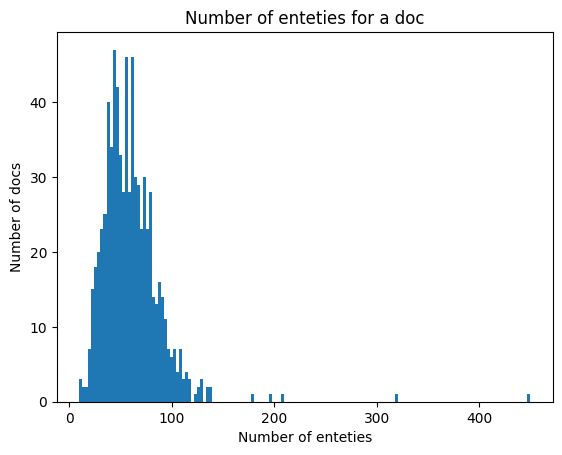

In [13]:
plt.hist(ent_in_text, bins=150)
plt.xlabel("Number of enteties")
plt.ylabel("Number of docs")
plt.title("Number of enteties for a doc")
plt.show()

For the vast majority of texts, the number of entities found in the text is no more than 100, and for the most part the texts themselves do not exceed 500 words. The most common entities are those denoting people and organizations.

##### 3. Data Parsing & Target Generation:

Ожидаемые дополнительные функции, которые вы должны реализовать:

- `build_examples_from_nerel(records: List[dict], event_list: List[str]) -> List[dict]` - для каждого документа вернуть словарь с полями: `text`, `tokens` (word-tokenization по пробелам), `token_spans` (символьные оффсеты слов), `tags` (BIO per token), `cls_vec` (multihot длиной len(event_list)).

- `make_event_list(records, K=30)` - собрать топ-K типов событий/relations и вернуть список.



**Правила BIO и сопоставления:**

- Токенизация для BIO - простая `text.split()` (по пробелам). Офсеты токенов вычисляются на основе поиска токена в тексте (учтите повторы; используйте скользящий указатель).
- Для каждой сущности (start, end - символьные оффсеты) пометьте токены, которые пересекаются с интервалом сущности.
- Метки: `B-TYPE`, `I-TYPE`, `O`.



In [14]:
import re
from collections import Counter

# NEREL string format parsing functions
def parse_entity_line(line: str):
    parts = line.split('\t')
    if len(parts) < 3:
        return None
    ent_id = parts[0].strip()
    type_pos = parts[1].strip()
    text = parts[2].strip() if len(parts) > 2 else ''
    m = re.match(r'(\S+)\s+(\d+)\s+(\d+)', type_pos)
    if not m:
        return None
    ent_type = m.group(1)
    start = int(m.group(2))
    end = int(m.group(3))
    return {'id': ent_id, 'type': ent_type, 'start': start, 'end': end, 'text': text}

def parse_relation_line(line: str):
    parts = line.split('\t')
    if len(parts) < 2:
        return None
    rel_id = parts[0].strip()
    body = parts[1].strip()
    m = re.match(r'(\S+)\s+Arg1:(\S+)\s+Arg2:(\S+)', body)
    if not m:
        return None
    rel_type = m.group(1)
    arg1 = m.group(2); arg2 = m.group(3)
    return {'id': rel_id, 'type': rel_type, 'arg1': arg1, 'arg2': arg2}

In [32]:
def whitespace_tokenize_with_offsets(text: str):
    tokens = []
    spans = []
    for m in re.finditer(r'\S+', text):
        tokens.append(m.group())
        spans.append((m.start(), m.end()))
    return tokens, spans

def make_event_list(records, K=30):
  """
    Extracts the top-K most frequent event and relation types from the dataset records.

    Args:
        records (List[dict]): The raw dataset records containing annotation layers.
        K (int, optional): The number of most frequent events to select. Defaults to 30.

    Returns:
        List[str]: A list of the K most frequent event/relation labels (classes).
    """

  counter = Counter()
  for record in records:
        for rel_line in record.get("relations", []):
            rel = parse_relation_line(rel_line)
            if rel:
                counter[rel["type"]] += 1
  return [t for t, _ in counter.most_common(K)]

def build_examples_from_nerel(records, event_list):
    """
    Processes raw NEREL records into structured training examples with aligned tokens,
    BIO tags, and document-level event vectors.

    For each document, this function performs:
    1. Whitespace tokenization.
    2. Alignment of character offsets (spans) for each token.
    3. Generation of BIO tags for NER at the token level.
    4. Construction of a multi-hot vector for document-level event classification.

    Args:
        records (List[dict]): A list of raw document records from the NEREL dataset.
        event_list (List[str]): The fixed list of target event/relation classes used
                                for creating the multi-hot vectors.

    Returns:
        List[dict]: A list of processed examples, where each dict contains:
            - 'text': Original text string.
            - 'tokens': List of string tokens.
            - 'token_spans': List of (start, end) character offsets for each token.
            - 'tags': List of BIO tags aligned to tokens.
            - 'cls_vec': Multi-hot vector (list/array) of length len(event_list).
    """
    examples = []
    for record in records:
        text = record["text"]
        tokens, token_spans = whitespace_tokenize_with_offsets(text)
        tags = ["O"] * len(tokens)

        # collecting all entities with span
        entities = []
        for entity in record["entities"]:
            m = re.match(r"^T\d+\t([A-Z_]+)\s", entity)
            if not m:
                continue
            entity_type = m.group(1)

            spans = [(int(s), int(e)) for s, e in re.findall(r"(\d+)\s+(\d+)", entity)]
            for (ent_start, ent_end) in spans:
                entities.append({
                    "type": entity_type,
                    "start": ent_start,
                    "end": ent_end,
                    "text": entity
                })

        # removing the nested entities (keeping the larger one)
        entities.sort(key=lambda x: (x["start"], -(x["end"] - x["start"])))
        filtered_entities = []
        for e in entities:
            if any(e["start"] >= f["start"] and e["end"] <= f["end"] for f in filtered_entities):
                # if this entity is completely nested in an already added one, then skip
                continue
            filtered_entities.append(e)

        # marking up tokens based on nesting
        for e in filtered_entities:
            ent_start, ent_end = e["start"], e["end"]
            entity_type = e["type"]
            overlaps = [
                i for i, (span_start, span_end) in enumerate(token_spans)
                if not (span_end <= ent_start or span_start >= ent_end)
            ]

            if not overlaps:
                continue

            for j, token_num in enumerate(overlaps):
                prefix = "B" if j == 0 else "I"
                tags[token_num] = f"{prefix}-{entity_type}"

        # CLS-vector
        parsed_relations = []
        for rel_line in record.get("relations", []):
            rel = parse_relation_line(rel_line)
            if rel is not None:
                parsed_relations.append(rel)

        cls_vec = []
        for rel_type in event_list:
            found = False
            for r in parsed_relations:
                if r["type"] == rel_type:
                    found = True
                    break
            cls_vec.append(1 if found else 0)

        examples.append({
            "text": text,
            "tokens": tokens,
            "tags": tags,
            "token_spans": token_spans,
            "cls_vec": cls_vec
        })

    return examples


event_list_train = make_event_list(train)
event_list_dev = make_event_list(dev)
event_list_test = make_event_list(test)
event_list_all = sorted(set(event_list_train + event_list_dev + event_list_test))


examples_train = build_examples_from_nerel(train, event_list_all)
examples_dev = build_examples_from_nerel(dev, event_list_all)
examples_test = build_examples_from_nerel(test, event_list_all)

examples = examples_train + examples_dev + examples_test


In [33]:
import random
numbers = random.sample(range(201), 5)
for i in numbers:
  for j in examples_train[i]:
    print(examples_train[i][j])


Путин подписал «указ против анонимности в Сети»

Зелёный аноним
Сегодня, 11 мая 2017 года, на сайте Кремля [http://kremlin.ru/acts/bank/41919 опубликован] подписанный президентом России Владимиром Путиным документ «Стратегия развития информационного общества в Российской Федерации на 2017—2030 годы», который ряд СМИ назвали «указом против анонимности в Сети».

Предложенные меры представляются авторам документа необходимыми для «формирования в России информационного пространства, учитывающего потребности граждан и общества в получении качественных и достоверных сведений».

Документ предлагает исключить анонимность определённых групп пользователей Сети, их «безответственность и безнаказанность». Также планируется создать специальную систему, гарантирующую личную безопасность пользователей и конфиденциальность их информации, — так говорится в тексте, который можно найти на сайте Кремля.

В интервью Life.ru советник президента по Интернету Герман Клименко сказал: «Видеть в Стратегии развит

##### 4. Tokenization & Label Alignment


In [34]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("DeepPavlov/rubert-base-cased", use_fast=True)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [35]:
unique_labels = set()
for ex in examples:
    unique_labels.update(ex["tags"])
unique_labels.add("O")
label_list = sorted(unique_labels)
label2id = {lab: i for i, lab in enumerate(label_list)}
id2label = {i: lab for lab, i in label2id.items()}

def changing_labels(examples):
  for ex in examples:
    ex["tags"] = [label2id[t] for t in ex["tags"]]
  return examples

examples_train = changing_labels(examples_train)
examples_dev = changing_labels(examples_dev)
examples_test = changing_labels(examples_test)

In [36]:
def tokenize_and_align_labels(example, tokenizer, max_length=512):
    """
    Tokenizes input text and aligns word-level BIO tags with subword tokens for NER training.

    Since Transformer tokenizers split words into subwords, this function aligns the original
    word-level tags to the new token sequence. It implements the standard strategy:
    1. The first subword of a word receives the original label ID.
    2. Subsequent subwords of the same word are assigned the special ID -100 (ignored by CrossEntropyLoss).
    3. Document-level labels (cls_labels) are passed through unchanged.

    Args:
        examples (dict): A batch of examples containing 'tokens' (words), 'tags' (BIO labels),
                         and 'cls_vec' (document classification targets).
        tokenizer: The pre-trained tokenizer (must be an instance of PreTrainedTokenizerFast).
        label2id (dict): A mapping from BIO tag strings to integer IDs.
        max_length (int): Maximum sequence length for truncation/padding.

    Returns:
        dict: A dictionary of model inputs compatible with Hugging Face models:
            - 'input_ids': List of token IDs.
            - 'attention_mask': Binary mask avoiding attention on padding tokens.
            - 'labels': Aligned token-level labels (including -100 for subwords/padding).
            - 'cls_labels': Document-level multi-hot vectors for event classification.
    """
    tokenized_input = tokenizer(example['tokens'], is_split_into_words=True, truncation=True, max_length=max_length, return_offsets_mapping=False) # The argument is_split_into_words=True says that ready-made tokens are being transmitted, not split text

    word_ids = tokenized_input.word_ids()
    previous_word_idx = None
    label_ids = []

    for word_idx in word_ids:
        if word_idx is None:
            label_ids.append(-100)
        elif word_idx != previous_word_idx:
            label_ids.append(example["tags"][word_idx])
        else:
            label_ids.append(-100)
        previous_word_idx = word_idx

    tokenized_input["labels"] = label_ids
    tokenized_input["cls_labels"] = example["cls_vec"]

    return tokenized_input


In [37]:
from datasets import Dataset, DatasetDict

train_dataset = Dataset.from_list(examples_train)
dev_dataset = Dataset.from_list(examples_dev)
test_dataset = Dataset.from_list(examples_test)

dataset = DatasetDict({
    "train": train_dataset,
    "validation": dev_dataset,
    "test": test_dataset
})

dataset = dataset.map(
    lambda x: tokenize_and_align_labels(x, tokenizer),
    batched=False,
    remove_columns=["text", "tokens", "tags", 'cls_vec', "token_spans"],
)


Map:   0%|          | 0/746 [00:00<?, ? examples/s]

Map:   0%|          | 0/94 [00:00<?, ? examples/s]

Map:   0%|          | 0/93 [00:00<?, ? examples/s]

In [38]:
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels', 'cls_labels'],
        num_rows: 746
    })
    validation: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels', 'cls_labels'],
        num_rows: 94
    })
    test: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels', 'cls_labels'],
        num_rows: 93
    })
})


In [39]:
print(dataset['train'][0])

{'input_ids': [101, 95305, 4262, 128, 60277, 851, 42540, 3648, 38472, 42203, 845, 23801, 59297, 52997, 13507, 845, 76911, 11343, 134, 11564, 134, 6564, 3955, 156, 9452, 113798, 112636, 31226, 128, 146, 6023, 134, 9580, 130, 28076, 134, 132, 50863, 16597, 23139, 18023, 845, 13507, 128, 23801, 59297, 34768, 4425, 845, 76911, 128, 114749, 128, 60277, 851, 42540, 3648, 38472, 128, 4721, 2743, 14650, 8609, 130, 17164, 12618, 23139, 132, 108, 781, 7887, 13300, 30708, 130, 31536, 4737, 19334, 2068, 73786, 10573, 108, 36509, 108, 845, 28279, 6163, 3231, 71448, 29544, 1533, 128, 845, 13507, 128, 80730, 12727, 130, 37548, 79542, 23139, 851, 23801, 59297, 34768, 4425, 128, 18715, 851, 42203, 156, 12821, 68697, 1755, 73326, 869, 99045, 86763, 851, 869, 81203, 45929, 53525, 128, 7085, 39145, 26794, 146, 128, 12140, 52686, 128, 5296, 15371, 61436, 626, 17795, 103843, 110988, 44414, 4367, 130, 6589, 26794, 128, 9696, 32162, 1641, 68697, 1766, 67162, 128, 5296, 114000, 22240, 89125, 128, 9696, 42540, 

In [41]:
from transformers import DataCollatorForTokenClassification
from torch.utils.data import DataLoader

data_collator = DataCollatorForTokenClassification(tokenizer)

train_dataloader = DataLoader(
    dataset["train"],
    batch_size=16,
    shuffle=True,
    collate_fn=data_collator
)

test_dataloader = DataLoader(
    dataset["test"],
    batch_size=16,
    shuffle=True,
    collate_fn=data_collator
)

dev_dataloader = DataLoader(
    dataset["validation"],
    batch_size=16,
    shuffle=True,
    collate_fn=data_collator
)
print("SAmples for training:", len(dataset["train"]))

SAmples for training: 746


In [42]:
print(dataset.shape)

{'train': (746, 5), 'validation': (94, 5), 'test': (93, 5)}


In [43]:
example = dataset["train"][1]

print("input_ids:", len(example["input_ids"]))
print("labels:", len(example["labels"]))
print("cls_labels:", len(example["cls_labels"]))

input_ids: 512
labels: 512
cls_labels: 34


##### 5. Model `JointModel` + custom loss (uncertainty weighting)


In [44]:
import torch
import torch.nn as nn
from transformers import AutoModel


class JointModel(nn.Module):
    def __init__(self, model_name: str, num_token_labels: int, num_cls_labels: int, dropout_prob: float = 0.1, use_uncertainty_weight: bool = True):
        super().__init__()

        # Encoder
        self.encoder = AutoModel.from_pretrained(model_name)
        # Retrieve hidden size to initialize classification heads
        hidden_size = self.encoder.config.hidden_size

        # Dropout
        # Zero out 10% of neurons during training to prevent overfitting
        self.dropout = nn.Dropout(dropout_prob)

        # NER Classifier
        # Arguments: input dimension (encoder output) and output dimension (number of classes)
        self.token_cls = nn.Linear(hidden_size, num_token_labels)

        # CLS Token Classifier (multilabel events)
        self.cls_cls = nn.Linear(hidden_size, num_cls_labels)

        # Loss Functions
        # Instruct the loss function to ignore specific positions (like padding) during calculation
        self.token_loss_fct = nn.CrossEntropyLoss(ignore_index=-100)
        self.cls_loss_fct = nn.BCEWithLogitsLoss()

        # Flag for uncertainty weighting: balancing task losses based on their uncertainty.
        # If the model is confident (low uncertainty -> small sigma), it assigns a higher weight to the loss.
        # If the model struggles (high uncertainty -> large sigma), the loss is attenuated to avoid disrupting convergence.
        self.use_uncertainty_weight = use_uncertainty_weight

        if use_uncertainty_weight:
            # nn.Parameter indicates to PyTorch that this is a learnable model parameter updated during backward().
            # During training, log_sigma values are updated by the optimizer alongside network weights.
            self.log_sigma_token = nn.Parameter(torch.tensor(0.0))
            self.log_sigma_cls = nn.Parameter(torch.tensor(0.0))

    def forward(self, input_ids, attention_mask, labels=None, cls_labels=None, **kwargs):
        # **kwargs handles any extra dataset fields not needed by the model (e.g., token_type_ids)

        # Pass through encoder
        outputs = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        # Embeddings of all tokens after the last BERT layer: [batch, seq_len, hidden]
        sequence_output = outputs.last_hidden_state

        # [CLS]: BERT adds a special [CLS] token at the beginning representing the "aggregated meaning" of the text.
        # Use pooler_output if available. Otherwise (e.g., RoBERTa/DeBERTa), take the first [CLS] vector from sequence_output.
        pooled_output = outputs.pooler_output if hasattr(outputs, "pooler_output") else sequence_output[:, 0]

        # Dropout
        sequence_output = self.dropout(sequence_output)
        pooled_output = self.dropout(pooled_output)

        # Predictions
        token_logits = self.token_cls(sequence_output)  # [batch, seq_len, num_token_labels]
        cls_logits = self.cls_cls(pooled_output)        # [batch, num_cls_labels]

        loss = None
        if labels is not None and cls_labels is not None:
            # Base losses
            token_loss = self.token_loss_fct(
                token_logits.view(-1, token_logits.shape[-1]),
                labels.view(-1)
            )
            cls_loss = self.cls_loss_fct(cls_logits, cls_labels.float())

            # Summation with uncertainty weighting
            if self.use_uncertainty_weight:
                token_term = torch.exp(-2.0 * self.log_sigma_token) * token_loss + self.log_sigma_token
                cls_term = torch.exp(-2.0 * self.log_sigma_cls) * cls_loss + self.log_sigma_cls
                loss = token_term + cls_term
            else:
                loss = token_loss + cls_loss

        return {
            "loss": loss,
            "token_logits": token_logits,
            "cls_logits": cls_logits,
        }

In [45]:
model = JointModel(
    model_name="DeepPavlov/rubert-base-cased-conversational",
    num_token_labels=len(label2id),
    num_cls_labels=len(event_list_all),
    use_uncertainty_weight=True
)


config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/714M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of the model checkpoint at DeepPavlov/rubert-base-cased-conversational were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


##### 6. Training / Validation



In [46]:
# Compute performance metrics for both model tasks:
# 1. NER (token-level): Evaluated using seqeval (standard library for BIO tagging schemes).
# 2. CLS (multi-label events): Evaluated using Micro-F1, Precision, and Recall.

from sklearn.metrics import f1_score, precision_score, recall_score
from seqeval.metrics import f1_score as seqeval_f1
from tqdm import tqdm
import numpy as np
import torch

def evaluate(model, dataloader, id2label, device):
    model.eval()
    all_true_tags = []
    all_pred_tags = []
    all_true_cls = []
    all_pred_cls = []
    total_loss = 0.0
    n_batches = 0

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            loss = outputs["loss"]
            total_loss += loss.item()
            n_batches += 1

            # Token-level
            logits = outputs["token_logits"].detach().cpu().numpy()
            preds = np.argmax(logits, axis=-1)
            labels = batch["labels"].cpu().numpy()

            for i in range(labels.shape[0]):
                pred_tags = []
                true_tags = []
                for p, l in zip(preds[i], labels[i]):
                    if l != -100:
                        pred_tags.append(id2label[p])
                        true_tags.append(id2label[l])
                all_pred_tags.append(pred_tags)
                all_true_tags.append(true_tags)

            # CLS-level
            cls_logits = outputs["cls_logits"].detach().cpu().numpy()
            cls_preds = (1 / (1 + np.exp(-cls_logits)) > 0.5).astype(int)  # sigmoid + threshold
            cls_labels = batch["cls_labels"].cpu().numpy()

            all_pred_cls.append(cls_preds)
            all_true_cls.append(cls_labels)

    # Metrics
    avg_loss = total_loss / n_batches if n_batches > 0 else 0.0

    token_f1 = seqeval_f1(all_true_tags, all_pred_tags)
    cls_f1 = f1_score(np.vstack(all_true_cls), np.vstack(all_pred_cls), average='micro')
    cls_precision = precision_score(np.vstack(all_true_cls), np.vstack(all_pred_cls), average='micro')
    cls_recall = recall_score(np.vstack(all_true_cls), np.vstack(all_pred_cls), average='micro')

    return {
        "loss": avg_loss,
        "token_f1": token_f1,
        "cls_f1": cls_f1,
        "cls_precision": cls_precision,
        "cls_recall": cls_recall,
    }


In [47]:
from tqdm import tqdm

num_epochs = 10
learning_rate = 5e-5
train_log = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    n_batches = 0

    for batch in tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs["loss"]

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        n_batches += 1

    avg_train_loss = total_loss / n_batches if n_batches > 0 else 0.0
    eval_results = evaluate(model, dev_dataloader, id2label, device)

    train_log.append({
        "epoch": epoch + 1,
        "train_loss": avg_train_loss ,
        "val_loss": eval_results["loss"],
        "token_f1": eval_results["token_f1"],
        "cls_f1": eval_results["cls_f1"]
    })

    print(f"Epoch {epoch+1}: train_loss={avg_train_loss :.4f}, val_loss={eval_results['loss']:.4f}, "
          f"token_f1={eval_results['token_f1']:.4f}, cls_f1={eval_results['cls_f1']:.4f}")


Evaluating: 100%|██████████| 6/6 [00:02<00:00,  2.17it/s]


Epoch 1: train_loss=2.6489, val_loss=2.3616, token_f1=0.0259, cls_f1=0.6779


Evaluating: 100%|██████████| 6/6 [00:02<00:00,  2.12it/s]


Epoch 2: train_loss=1.9820, val_loss=1.7528, token_f1=0.3634, cls_f1=0.6950


Evaluating: 100%|██████████| 6/6 [00:02<00:00,  2.21it/s]


Epoch 3: train_loss=1.4962, val_loss=1.4353, token_f1=0.4774, cls_f1=0.6944


Evaluating: 100%|██████████| 6/6 [00:02<00:00,  2.09it/s]


Epoch 4: train_loss=1.1737, val_loss=1.3088, token_f1=0.5318, cls_f1=0.7001


Evaluating: 100%|██████████| 6/6 [00:02<00:00,  2.09it/s]


Epoch 5: train_loss=0.9410, val_loss=1.2543, token_f1=0.5622, cls_f1=0.7034


Evaluating: 100%|██████████| 6/6 [00:02<00:00,  2.22it/s]


Epoch 6: train_loss=0.7776, val_loss=1.2132, token_f1=0.5828, cls_f1=0.7355


Evaluating: 100%|██████████| 6/6 [00:02<00:00,  2.19it/s]


Epoch 7: train_loss=0.6501, val_loss=1.2313, token_f1=0.5817, cls_f1=0.7320


Evaluating: 100%|██████████| 6/6 [00:02<00:00,  2.10it/s]


Epoch 8: train_loss=0.5611, val_loss=1.2627, token_f1=0.6094, cls_f1=0.7422


Evaluating: 100%|██████████| 6/6 [00:02<00:00,  2.11it/s]


Epoch 9: train_loss=0.5003, val_loss=1.2848, token_f1=0.5946, cls_f1=0.7384


Evaluating: 100%|██████████| 6/6 [00:02<00:00,  2.10it/s]

Epoch 10: train_loss=0.4477, val_loss=1.2952, token_f1=0.6058, cls_f1=0.7475


In [48]:
results = evaluate(model, test_dataloader, id2label, device)

print(f"Test loss: {results['loss']:.4f}")
print(f"Token-level F1 (seqeval): {results['token_f1']:.4f}")
print(f"CLS micro-F1: {results['cls_f1']:.4f}")
print(f"CLS precision: {results['cls_precision']:.4f}")
print(f"CLS recall: {results['cls_recall']:.4f}")


Evaluating: 100%|██████████| 6/6 [00:02<00:00,  2.09it/s]

Test loss: 1.2726
Token-level F1 (seqeval): 0.5990
CLS micro-F1: 0.7530
CLS precision: 0.7948
CLS recall: 0.7154


##### 7. Inference & Error Analysis. Quantization


In [49]:
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def infer(model, tokenizer, text, id2label, event_list_all, threshold=0.5, max_length=512):
    model.eval()

    # Tokenization
    inputs = tokenizer(
        text,
        return_tensors="pt",
        truncation=True,
        max_length=max_length,
        padding="max_length"
    ).to(device)

    with torch.no_grad():
        outputs = model(**inputs)

    # BIO
    token_logits = outputs["token_logits"][0]
    token_preds = torch.argmax(token_logits, dim=-1).cpu().numpy()
    tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])

    # Filter out special tokens and padding
    valid_tokens, valid_tags = [], []
    for t, p in zip(tokens, token_preds):
        if t not in ("[CLS]", "[SEP]", "[PAD]"):
            valid_tokens.append(t)
            valid_tags.append(id2label[p])

    # CLS-level
    cls_logits = outputs["cls_logits"].cpu()
    cls_probs = torch.sigmoid(cls_logits).numpy().flatten()
    cls_pred = (cls_probs > threshold).astype(int)

    result = {
        "tokens": valid_tokens,
        "bio_tags": valid_tags,
        "cls_probs": {label: float(p) for label, p in zip(event_list_all, cls_probs)},
        "cls_predicted": [label for label, p in zip(event_list_all, cls_pred) if p == 1],
    }
    return result


In [50]:
inf_text = [
    "Суд в Индии ходатайствует, чтобы медвузы включили в программу обучения курсы чистописания. Цель – чтобы почерк врачей мог разобрать обычный человек. Как сообщило ВВС, Высокий суд Пенджаба и Харьяны рассматривал дело, весьма далекое от вопросов каллиграфии. Речь шла об обвинении в мошенничестве и сексуальной эксплуатации. Но судья Джасгурпрет Сингх Пури, к собственному изумлению, не смог разобрать практически ни одного слова в документе медицинской экспертизы, написанном государственным врачом от руки. «Шокирует, что технологии и компьютеры легко доступны, а государственные врачи все еще пишут от руки так, что никто другой не может прочитать, разве что, возможно, кроме химиков», – написал судья Пури. Он обратился к правительству с ходатайством включить уроки по чистописанию в учебную программу медицинских вузов, а через два года внедрить по всей стране оцифровку медицинских документов. Пока этого не произойдет, все врачи должны четко выписывать рецепты заглавными буквами, постановил судья Пури.",
    "Госдума упростила прием на службу в органы внутренних дел. В первом чтении одобрен законопроект, который отменяет обязательную стажировку и испытательный срок для кандидатов и вводит новый порядок их профессиональной подготовки. Таким образом планируется решить кадровую проблему в полиции. Инициатива направлена на ускорение оформления сотрудников и устранение задержек при комплектовании подразделений МВД. Во вторник, 7 октября, Госдума на пленарном заседании приняла в первом чтении законопроект, отменяющий обязательную стажировку и испытательный срок для граждан, поступающих на службу в органы внутренних дел. Документ также предусматривает изменение сроков первого контракта и обновленный порядок профессиональной подготовки новых сотрудников. По итогам голосования законопроект поддержали 350 депутатов, 4 выступили против, 23 воздержались. После первого чтения документ направлен в комитет по безопасности и противодействию коррупции для подготовки ко второму чтению.",
    "В Нижнем Новгороде в возрасте 37 лет скончался лучший повар Юга России Олег Колисниченко. Причиной смерти стал инсульт. Повара отвезли в больницу прямо с рабочего места, экстренно прооперировали, но через четверо суток, несмотря на усилия врачей, он умер. Колисниченко прославился благодаря проекту La Fabbrica by Novikov в Ростове-на-Дону и переехал в Нижний в прошлом году. Проблем со здоровьем у него не отмечали: он занимался спортом и регулярно проходил обследования.",
    'Президент Национального объединения строителей Антон Глушков рассказал, что организация поддержала идею выдавать льготную ипотеку молодым семьям без детей под обязательства по рождению ребенка. По словам Глушкова, для этого уже придумано несколько конструкций, однако вопрос заключается в наличии ресурсов. В Госдуме инициативу раскритиковали. Зампред комитета по строительству Владимир Кошелев в разговоре с «Газетой.Ru» усомнился в надежности этой схемы и заявил, что рождение ребенка — это не сдача отчета в установленный дедлайн.',
    'В Новосибирске пьяный мужчина напал на кондуктора и избил ногами пассажирку, которая заступилась за него. Об этом сообщает «КП — Новосибирск». «Как утверждают очевидцы, конфликт вспыхнул из-за того, что долго выходил чек об оплате. Нетрезвый мужик набросился на кондуктора, повредил кассовый аппарат, распылил в салоне перцовый баллончик, а затем напал на пассажирку, которая пыталась заступиться за кондуктора», — говорится в публикации. Судя по кадрам, пьяный мужчина вытолкал женщину из салона транспорта и принялся топтать ее голову ногами, пока его не оттащил другой человек. Женщина получила серьезные травмы. Кадры с дракой опубликовало сообщество «Инцидент Новосибирск».',
    'Повышение комиссий для продавцов на маркетплейсах не отразится на ценах для потребителей. Об этом «Газете.Ru» заявил генеральный директор «Infoline-аналитика» Михаил Бурмистров, комментируя изменения в тарифах Ozon. Бурмистров пояснил, что Ozon увеличил комиссии для продавцов, так как аккумулирует ресурсы для «рывка» к высокому сезону. «От того, насколько успешно пройдут распродажи, зависит и рост самих площадок, и рост бизнеса продавцов в следующем году», — рассказал Бурмистров. Маркетплейс ранее сообщил, что с 7 октября комиссия за продажу для продавцов, которые торгуют со своего склада, вырастет, в среднем, на 4% по всем категориям товаров. Для некоторых селлеров, которые размещают товары на складе Ozon, комиссии тоже изменятся: на 1% вырастет тариф за продажу товаров для дома.',
    'Сравнительно недолгим оказался брак известного шефа страны Константина Ивлева с его молодой женой Валерией. Не прошло и четырех лет, как девушка открыто объявила о разводе. «Мы с Константином больше не вместе, остались в хороших отношениях и с уважением друг к другу. Комментарии по этому поводу давать не буду», – сообщила об этом на своей страничке в соцсети Валерия.',
    'Банда наемных убийц собиралась убивать возле детского сада. В Австралии перехватили «команду убийц» рядом с детским садом. Предполагаемой “команде убийц” предъявлены обвинения после ареста по пути к совершению смертоносного преступления возле детского сада в австралийском Сиднее. Полиция утверждает, что они установили личность троицы, "мобилизовавшейся" для убийства мужчины возле детского центра на юго-западе города.'
]

In [51]:
for text in inf_text:
  result = infer(model, tokenizer, text, id2label, event_list_all, threshold=0.5)

  for i in text.split('.'):
    print('\n' + i)


  print("\nTokens with BIO:")
  for t, tag in zip(result["tokens"], result["bio_tags"]):
      print(f"{t:15} {tag}")


  print("\nPredicted CLS events:")
  for ev, prob in result["cls_probs"].items():
      if prob > 0.3:
          print(f"{ev:25}  p={prob:.3f}")


Суд в Индии ходатайствует, чтобы медвузы включили в программу обучения курсы чистописания

 Цель – чтобы почерк врачей мог разобрать обычный человек

 Как сообщило ВВС, Высокий суд Пенджаба и Харьяны рассматривал дело, весьма далекое от вопросов каллиграфии

 Речь шла об обвинении в мошенничестве и сексуальной эксплуатации

 Но судья Джасгурпрет Сингх Пури, к собственному изумлению, не смог разобрать практически ни одного слова в документе медицинской экспертизы, написанном государственным врачом от руки

 «Шокирует, что технологии и компьютеры легко доступны, а государственные врачи все еще пишут от руки так, что никто другой не может прочитать, разве что, возможно, кроме химиков», – написал судья Пури

 Он обратился к правительству с ходатайством включить уроки по чистописанию в учебную программу медицинских вузов, а через два года внедрить по всей стране оцифровку медицинских документов

 Пока этого не произойдет, все врачи должны четко выписывать рецепты заглавными буквами, постан

In [59]:
import torch
import time
from sklearn.metrics import f1_score

# Model evaluation function
def evaluate_model(model, dataloader, device, threshold=0.5):
    model.eval()
    all_preds, all_labels = [], []
    all_token_preds, all_token_labels = [], []
    total_loss = 0.0
    n_batches = 0

    with torch.no_grad():
        for batch in dataloader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)

            if outputs["loss"] is not None:
                total_loss += outputs["loss"].item()

            # CLS
            logits = outputs["cls_logits"].cpu()
            labels = batch["cls_labels"].cpu()
            preds = (torch.sigmoid(logits) > threshold).int()

            all_preds.append(preds)
            all_labels.append(labels)

            # Token-level
            token_logits = outputs["token_logits"].cpu()
            token_labels = batch["labels"].cpu()
            token_preds = token_logits.argmax(-1)

            mask = token_labels != -100
            all_token_preds.append(token_preds[mask])
            all_token_labels.append(token_labels[mask])

            n_batches += 1

    cls_preds = torch.cat(all_preds)
    cls_labels = torch.cat(all_labels)
    token_preds = torch.cat(all_token_preds)
    token_labels = torch.cat(all_token_labels)

    cls_f1 = f1_score(cls_labels.numpy(), cls_preds.numpy(), average="micro")
    token_f1 = f1_score(token_labels.numpy(), token_preds.numpy(), average="micro")

    avg_loss = total_loss / max(1, n_batches)
    return {"loss": avg_loss, "cls_f1": cls_f1, "token_f1": token_f1}


# Speed measurement
def measure_inference_time(model, dataloader, device, n_batches=10):
    model.eval()
    start = time.time()
    with torch.no_grad():
        for i, batch in enumerate(dataloader):
            if i >= n_batches:
                break
            batch = {k: v.to(device) for k, v in batch.items()}
            _ = model(**batch)
    end = time.time()
    return (end - start) / n_batches


# Create a fresh model instance for quantization to avoid any device state issues
model_for_quantization = JointModel(
    model_name="DeepPavlov/rubert-base-cased-conversational",
    num_token_labels=len(label2id),
    num_cls_labels=len(event_list_all),
    use_uncertainty_weight=True
)
# Load trained weights into this new model instance
model_for_quantization.load_state_dict(model.state_dict())
# Move to CPU explicitly
model_for_quantization.to("cpu")

# Now quantize this CPU model
quantized_model = torch.quantization.quantize_dynamic(
    model_for_quantization,
    {torch.nn.Linear},
    dtype=torch.qint8
)

Some weights of the model checkpoint at DeepPavlov/rubert-base-cased-conversational were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/tmp/ipython-input-4156240774.py:79: DeprecationWarning: torch.ao.quantization is deprecated and 

In [60]:
# Performance Benchmarking
cpu_device = torch.device("cpu")

# Measure original model on CPU
model.to(cpu_device)
orig_time = measure_inference_time(model, dev_dataloader, cpu_device)

# Measure quantized model on CPU (it's already on CPU)
quant_time = measure_inference_time(quantized_model, dev_dataloader, cpu_device)

# Evaluate original model on CPU
model.to(cpu_device)
orig_metrics = evaluate_model(model, dev_dataloader, cpu_device, threshold=0.5)

# Evaluate quantized model on CPU
quant_metrics = evaluate_model(quantized_model, dev_dataloader, cpu_device, threshold=0.5)

print("\n  BENCHMARK RESULTS (CPU vs Quantized on CPU)")
print(f"Average Inference Time (per batch):")
print(f"  • Original (CPU):  {orig_time:.4f} sec")
print(f"  • Quantized (CPU): {quant_time:.4f} sec  ({orig_time / quant_time:.2f}x faster)")
print()
print(f"Impact on Metrics:")
print(f"  • Token F1: {orig_metrics['token_f1']:.4f} -> {quant_metrics['token_f1']:.4f}")
print(f"  • CLS F1:   {orig_metrics['cls_f1']:.4f} -> {quant_metrics['cls_f1']:.4f}")
print(f"  • Loss:     {orig_metrics['loss']:.4f} -> {quant_metrics['loss']:.4f}")


  BENCHMARK RESULTS (CPU vs Quantized on CPU)
Average Inference Time (per batch):
  • Original (CPU):  9.6422 sec
  • Quantized (CPU): 8.4507 sec  (1.14x faster)

Impact on Metrics:
  • Token F1: 0.8175 -> 0.7977
  • CLS F1:   0.7475 -> 0.7263
  • Loss:     1.3028 -> 1.2505


## Conclusion & Results Analysis

This project demonstrated the feasibility of a **Joint Multi-Task Model** (BERT-based) for simultaneous Named Entity Recognition (NER) and Event Classification on the NEREL dataset.

### 1. Performance Overview
The model achieved robust performance on the document-level classification task, while the token-level NER task highlighted specific challenges in semantic disambiguation.
* **Event Classification (CLS):** Achieved **Micro-F1 ~0.75**. The model shows high precision (~0.79), indicating reliable detection of relations when confident.
* **NER (Token-level):** Achieved **F1 ~0.60 (Test Set)** / **0.80 (Dev Set)**.

### 2. Error Analysis
A qualitative analysis of the inference results revealed the following insights:
* **Semantic Ambiguity:** While the model captures syntactic structures well, it struggles to distinguish between semantically similar entities, such as `PROFESSION`, `ORGANIZATION`, and `LOCATION`.
* **Compound Entities:** Long, multi-token entities (e.g., complex geographical names or media titles) occasionally suffer from fragmented BIO tags (broken spans or duplication).
* **Class Imbalance & Overconfidence:** The Event Classifier exhibits calibration issues. It tends to be overconfident in frequent classes like `PARTICIPANT_IN` and `WORKS_AS`. Conversely, classes like `HAS_CAUSE` or `LOCATED_IN` often receive lower probability scores (0.6–0.8), even on correct predictions. This suggests that **data noise** or annotation inconsistencies might be present in the training set.

### 3. Optimization & Benchmarking
To optimize the model for production environments without GPU access, I implemented **Dynamic Quantization (Int8)**.
* **Speedup:** The quantized model provided a **1.14x speedup** on CPU inference (9.6s $\to$ 8.45s per batch).
* **Trade-off:** The performance cost was minimal, with only a slight drop in Token F1 (0.81 $\to$ 0.79) and CLS F1 (0.74 $\to$ 0.72), proving that quantization is a viable strategy for this architecture.

### 4. Future Improvements
* **Data Cleaning:** Addressing the noisy annotation labels suspected during error analysis.
* **Handling Imbalance:** Implementing weighted loss or focal loss to mitigate the overconfidence in frequent event classes.
* **Architecture:** Experimenting with CRF (Conditional Random Fields) layer on top of BERT to enforce valid BIO-tag transitions and fix fragmented entities.